In [4]:
import numpy as np
import random
import torch
import importlib
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

import sys
sys.path.append('../')

from models.network import AutoEncoder
from data.data import ImNetImageSamples
from utils.debugger import MyDebugger
from torch.multiprocessing import Pool, Process, set_start_method

import matplotlib.pyplot as plt

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


def split(a, n):
    k, m = divmod(len(a), n)
    return [a[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n)]

## folder for testing
is_svr = True
epoch = 1000
use_phase = False
phase = 2

testing_folder = r'./../pretrain/origin/' + ('image_encoder/' if is_svr else 'phase_2_model')
config_path = os.path.join(testing_folder, 'config.py')
network_path = os.path.join(testing_folder, f'model_epoch{"_" + str(phase) if use_phase and not is_svr else ""}_{epoch}.pth')

## import config here
spec = importlib.util.spec_from_file_location('*', config_path)
config = importlib.util.module_from_spec(spec)
spec.loader.exec_module(config)

## dataload
### create dataset
data_path = r'./../data/all_vox256_img/all_vox256_img_test.hdf5'

testing_flag = True
if os.path.exists(config.data_path) and not testing_flag:
    data_path = config.data_path

model_type = f"AutoEncoder-{config.encoder_type}-{config.decoder_type}" if config.network_type == 'AutoEncoder' else f"AutoDecoder-{config.decoder_type}"

samples = ImNetImageSamples(data_path=data_path)

In [7]:
## loading index
sample_interval = 1
resolution = 64
max_batch = 20000
save_deformed = True
thershold = 0.01
with_surface_point = True

device_count = 1 # torch.cuda.device_count()
device_ratio = 1
worker_nums = int(device_count * device_ratio)
testing_cnt = 20

args = [(samples[i][0][0], resolution, max_batch, (-0.5, 0.5), thershold,
         samples.obj_paths[i], with_surface_point, i) for i in range(len(samples)) if
        i % sample_interval == 0]
random.shuffle(args)
args = args[:testing_cnt]
splited_args = split(args, worker_nums)
final_args = [(splited_args[i], network_path, config_path, i % device_count) for i in range(worker_nums)]

((1, 128, 128), <matplotlib.image.AxesImage at 0x7f1f8f6100a0>)

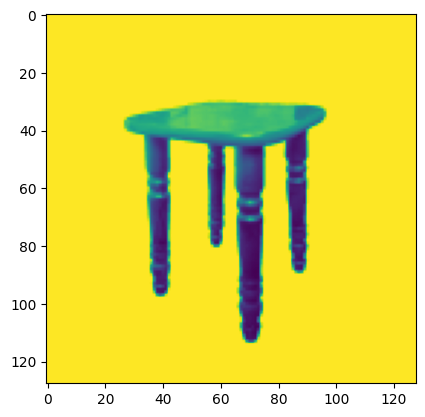

In [8]:
import cv2
target_wh = 128, 128

img = np.ones((1, target_wh[1], target_wh[0]), dtype=np.uint8) * 255

img_loaded = cv2.imread('masked-chair_1.png')
if img_loaded.shape[0] > img_loaded.shape[1]:
    res_wh = (
        int(img_loaded.shape[1] / (img_loaded.shape[0] // target_wh[0])), 
        target_wh[1]
    )
else:
    res_wh = (
        target_wh[0],
        int(img_loaded.shape[0] / (img_loaded.shape[1] // target_wh[1])), 
    )
    
additional_shift_wh = (
    (target_wh[0] - res_wh[0])//2,
    (target_wh[1] - res_wh[1])//2
)

img_loaded = cv2.resize(img_loaded, res_wh, interpolation=cv2.INTER_AREA)
img_loaded = img_loaded[..., 0]
img[:, additional_shift_wh[1]: res_wh[1]+additional_shift_wh[1], additional_shift_wh[0]: res_wh[0] + additional_shift_wh[0]] = img_loaded
img = img.astype(np.float32)
img /= 255
img.shape, plt.imshow(img[0])

(64,
 20000,
 (-0.5, 0.5),
 0.01,
 '03001627/d16b62da42fa61f0cbce248a4e686c70',
 True)

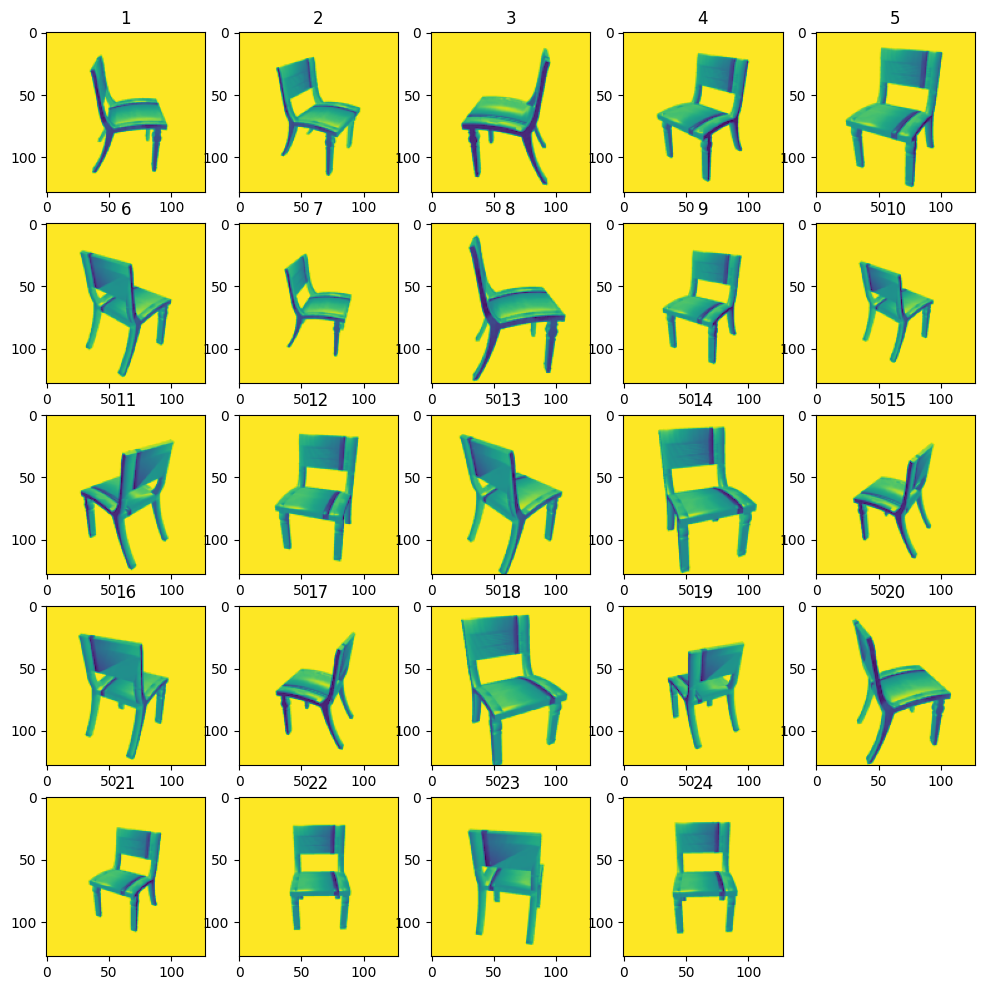

In [69]:
indx = 0
obj_indx = 6
find_obj_name = '03001627/d16b62da42fa61f0cbce248a4e686c70'
# '03001627/d16b62da42fa61f0cbce248a4e686c70'
# '04256520/db7851745fb04cf732388c13cc4a0ba3' 
# '03001627/d66b701631851e7b4b19d2c99e22ffe0'
# '04256520/db7851745fb04cf732388c13cc4a0ba3'
# '02691156/fb0f2907b977e7cb67c5e3041553656b' 
# '03001627/d16b62da42fa61f0cbce248a4e686c70'

img, resolution, max_batch, space_range, thresh, obj_path, sur_point, indx_sample = final_args[indx][0][obj_indx]

if find_obj_name is not None:
    indx_sample = samples.obj_paths.index(find_obj_name)
    img = samples.data_pixels[indx_sample, 0]
    obj_path = find_obj_name
    
gt_voxel, gt_points, gt_values = (
    samples.data_voxels[indx_sample], 
    samples.data_points[indx_sample], 
    samples.data_values[indx_sample]
)
net_path, conf_path = final_args[indx][1:-1]

all_img_view = samples.data_pixels[indx_sample].copy()

fig = plt.figure(figsize=(12, 12))
for i in range(1, len(all_img_view)+1):
    ax = fig.add_subplot(5,5,i)
    plt.imshow(np.squeeze(all_img_view[i-1]))
    plt.title(i)

resolution, max_batch, space_range, thresh, obj_path, sur_point

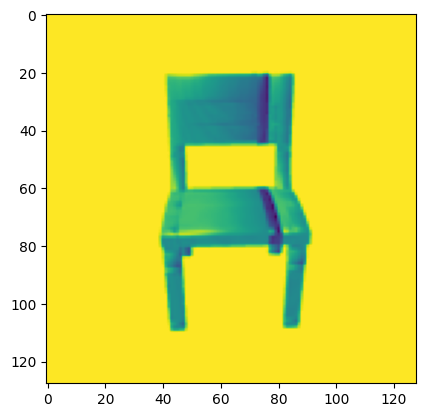

In [70]:
img = all_img_view[23] / 255.0
plt.imshow(img[0])

In [12]:
network_state_dict = torch.load(network_path)
network_state_dict, is_old_style_weights = AutoEncoder.process_state_dict(network_state_dict, type = 1)

if is_svr:
    if is_old_style_weights and config.encoder_type.upper() == '3DCNN':
        config = AutoEncoder.fix_old_weights_config(config)
    if not os.path.exists(config.auto_encoder_config_path):
        config.auto_encoder_config_path = os.path.join('./..', config.auto_encoder_config_path)
        config.auto_encoder_resume_path = os.path.join('./..', config.auto_encoder_resume_path)
    assert hasattr(config, 'auto_encoder_config_path') and os.path.exists(config.auto_encoder_config_path)
    auto_spec = importlib.util.spec_from_file_location('*', config.auto_encoder_config_path)
    auto_config = importlib.util.module_from_spec(auto_spec)
    auto_spec.loader.exec_module(auto_config)
    
    network = AutoEncoder(config=config)
    
    voxel_auto_encoder = AutoEncoder(config=auto_config)
    network_voxel_state_dict = torch.load(config.auto_encoder_resume_path)
    network_voxel_state_dict, _ = AutoEncoder.process_state_dict(network_voxel_state_dict, type = 1)
    voxel_auto_encoder.load_state_dict(network_voxel_state_dict)
    voxel_auto_encoder.to(device)
    voxel_auto_encoder.eval()
else:
    network = AutoEncoder(config=config).to(device)
network.load_state_dict(network_state_dict)
network = network.to(device)
_ = network.eval()

old style weights


In [71]:
thershold_1=thershold
thershold_2=0.01
space_range = (-0.5, 0.5)
max_batch = 20_000

img_torch = torch.from_numpy(img).float().to(device)
if is_svr:
    embedding = network(torch.from_numpy(img).float().to(device).unsqueeze(0))
    #embedding = voxel_auto_encoder(torch.from_numpy(gt_voxel).float().to(device).unsqueeze(0))
else:
    embedding = network(torch.from_numpy(gt_voxel).float().to(device).unsqueeze(0))
(vertices, polygons, vertices_deformed, polygons_deformed, 
 embedding, vertices_convex, bsp_convex_list, 
 convex_predictions_sum, point_value_prediction) = network.save_bsp_deform(
    inputs=None, file_path=None, resolution=resolution, max_batch=max_batch,
    space_range=space_range, thershold_1=thershold, embedding=embedding, save_output=False, return_voxel_and_values=True
)

In [ ]:
from utils.other_utils import write_ply_polygon

write_ply_polygon('mesh_deformed.ply', vertices_deformed, polygons_deformed)
write_ply_polygon('mesh_orginal.ply', vertices, polygons)

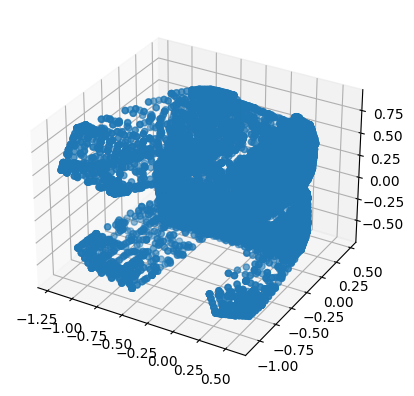

In [72]:
ax = plt.figure().add_subplot(projection='3d')
_ = ax.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], marker='o')

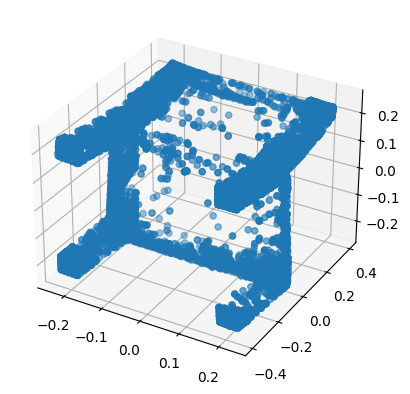

In [73]:
ax = plt.figure().add_subplot(projection='3d')
_ = ax.scatter(vertices_deformed[:, 0], vertices_deformed[:, 1], vertices_deformed[:, 2], marker='o')

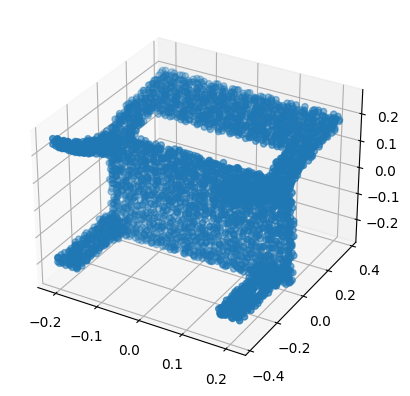

In [74]:
part_points = gt_points[gt_values[:, 0]>1e-4]
ax = plt.figure().add_subplot(projection='3d')
_ = ax.scatter(part_points[:, 0], part_points[:, 1], part_points[:, 2], marker='o')

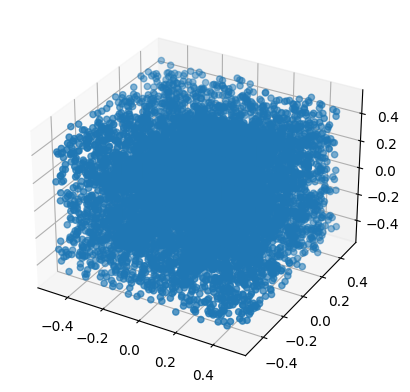

In [75]:
part_points = gt_points[gt_values[:, 0]<1e-4]
ax = plt.figure().add_subplot(projection='3d')
_ = ax.scatter(part_points[:, 0], part_points[:, 1], part_points[:, 2], marker='o')

## Normal consist

In [76]:
from evaluation.eval import calculate_normal_consistency
from evaluation.eval_utils import sample_points_polygon_vox64_njit, sample_points_polygon_vox64
from utils.other_utils import compute_vertices_normal

In [77]:
vertices.dtype, polygons.dtype, convex_predictions_sum.copy().dtype

(dtype('float64'), dtype('int64'), dtype('int64'))

In [78]:
sampled_points_normals = compute_vertices_normal(vertices_deformed, polygons_deformed)
sampled_points_normals.shape

(15060, 3)

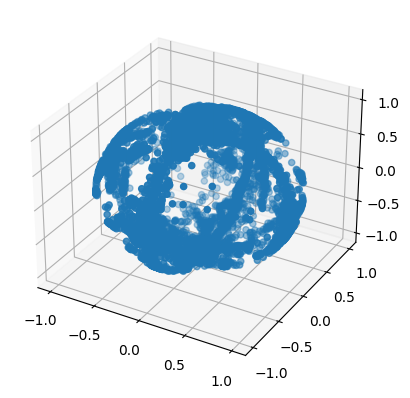

In [79]:
ax = plt.figure().add_subplot(projection='3d')
_ = ax.scatter(sampled_points_normals[:, 0], sampled_points_normals[:, 1], sampled_points_normals[:, 2], marker='o')

In [80]:
np.unique(convex_predictions_sum.copy())

array([0, 1, 2, 3, 4, 5])

In [81]:
#sample surface points
inverted_voxel = np.logical_not((convex_predictions_sum.copy() > 1e-4)).astype(np.float32)
sampled_points_normals = sample_points_polygon_vox64_njit(vertices_deformed, polygons_deformed, inverted_voxel, 16384) # 16384
point_coord = sampled_points_normals.copy()
point_coord = sampled_points_normals[:,:3]+sampled_points_normals[:,3:]*1e-4
point_coord = np.reshape(point_coord, [1,-1,3])
# point_coord = np.concatenate([point_coord, np.ones([1,point_coord.shape[1],1],np.float32) ],axis=2)
point_coord = torch.from_numpy(point_coord).to(device)
point_coord.shape

torch.Size([1, 16384, 3])

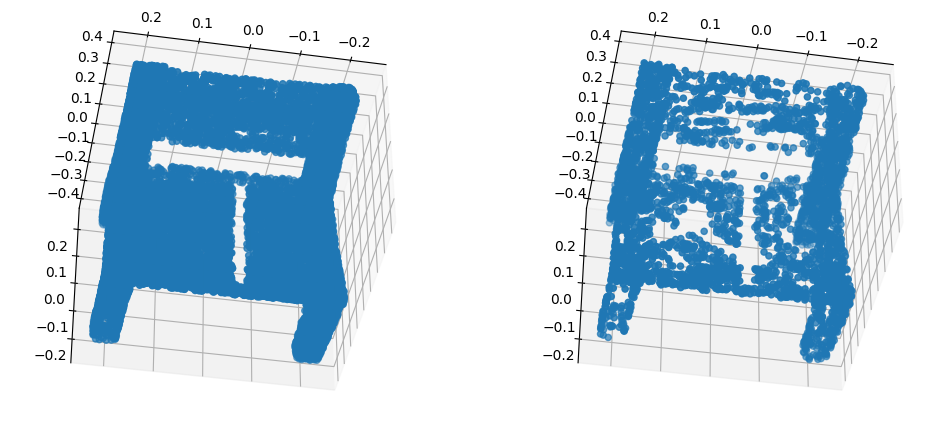

In [82]:
fig = plt.figure(figsize=(12,12))

ax = fig.add_subplot(121, projection='3d')
ax.view_init(elev=-40, azim=80)
_ = ax.scatter(sampled_points_normals[:, 0], sampled_points_normals[:, 1], sampled_points_normals[:, 2], marker='o')

ax = fig.add_subplot(122, projection='3d')
ax.view_init(elev=-40, azim=80)
_ = ax.scatter(sampled_points_normals[:4096, 0], sampled_points_normals[:4096, 1], sampled_points_normals[:4096, 2], marker='o')

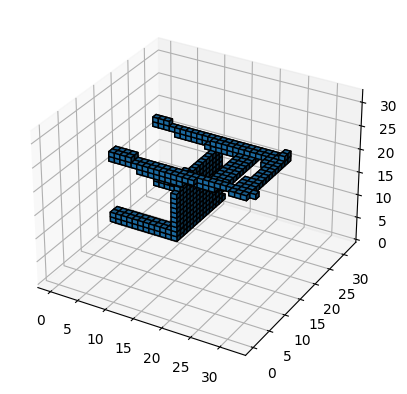

In [83]:
voxelarray = inverted_voxel.copy()
voxelarray = (voxelarray == 0).astype(np.int32)

ax = plt.figure().add_subplot(projection='3d')
_ = ax.voxels(voxelarray[::2, ::2, ::2], edgecolor='k')

In [84]:
sampled_points_normals.shape

(16384, 6)

18 16384


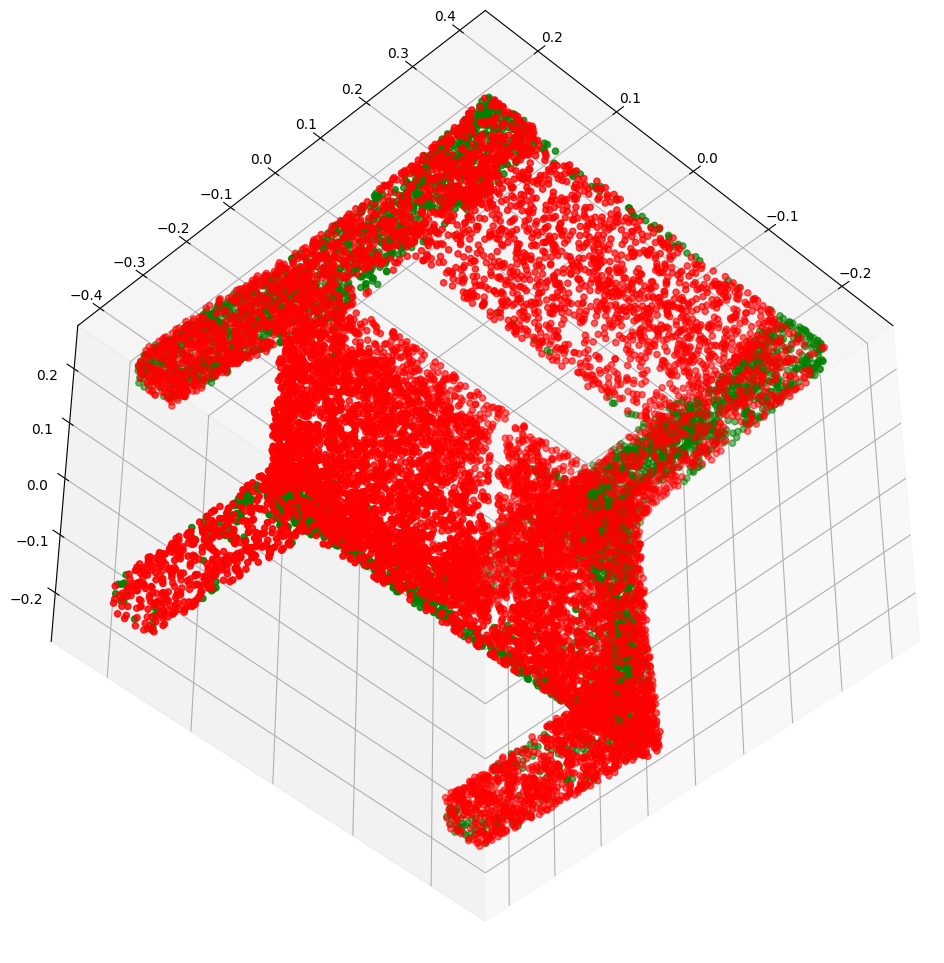

In [85]:
_, sample_points_value, _, _ = network.decoder(embedding, point_coord)
sample_points_value = sample_points_value.detach().cpu().numpy()
sampled_points_normals_outside = sampled_points_normals[sample_points_value[0,:,0]<1e-4]
sampled_points_normals_inside = sampled_points_normals[sample_points_value[0,:,0]>1e-4]

# %matplotlib widget
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(projection='3d')
ax.view_init(elev=-45, azim=45)

_ = ax.scatter(
    sampled_points_normals_outside[:, 0], sampled_points_normals_outside[:, 1], sampled_points_normals_outside[:, 2], 
    marker='o', c='green'
)
_ = ax.scatter(
    sampled_points_normals_inside[:, 0], sampled_points_normals_inside[:, 1], sampled_points_normals_inside[:, 2], 
    marker='o', c='red'
)

print(len(bsp_convex_list), len(sampled_points_normals))

In [86]:
# %matplotlib inline

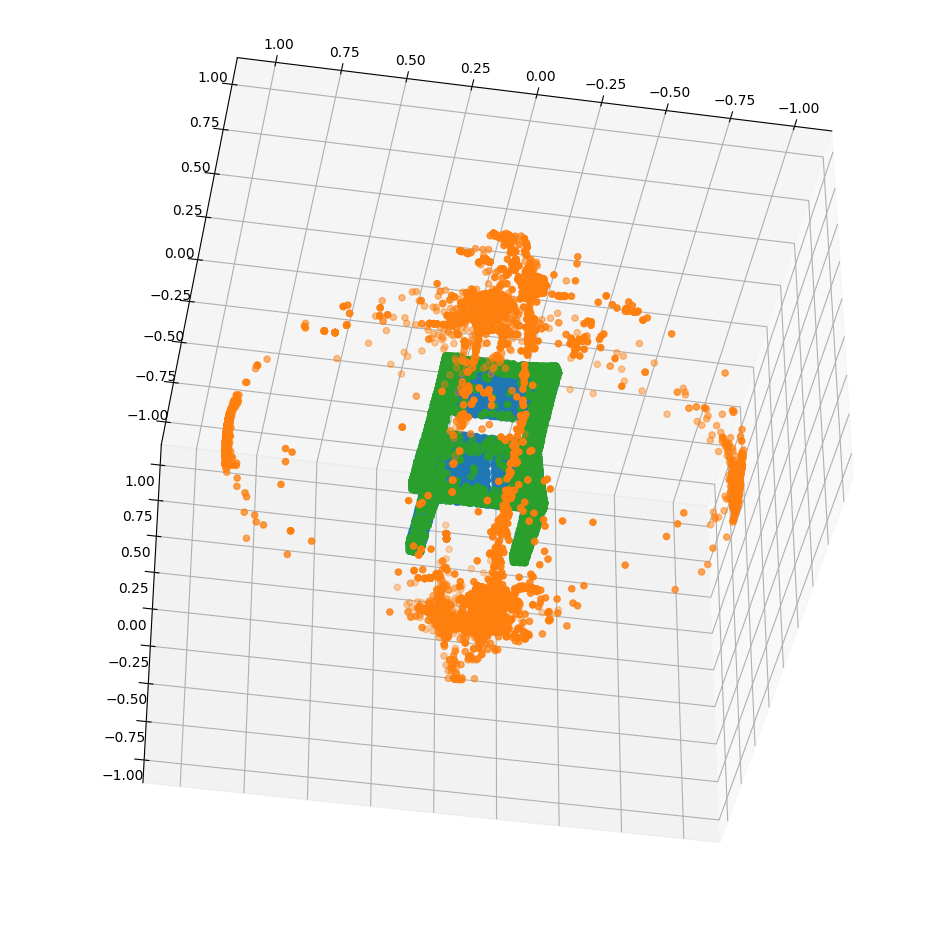

In [87]:
# %matplotlib widget
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(projection='3d')
ax.view_init(elev=-40, azim=80)

_ = ax.scatter(sampled_points_normals_inside[:, 0], sampled_points_normals_inside[:, 1], sampled_points_normals_inside[:, 2], marker='o')
_ = ax.scatter(sampled_points_normals_inside[:, 3], sampled_points_normals_inside[:, 4], sampled_points_normals_inside[:, 5], marker='o')

_ = ax.scatter(vertices_deformed[:, 0], vertices_deformed[:, 1], vertices_deformed[:, 2], marker='o')


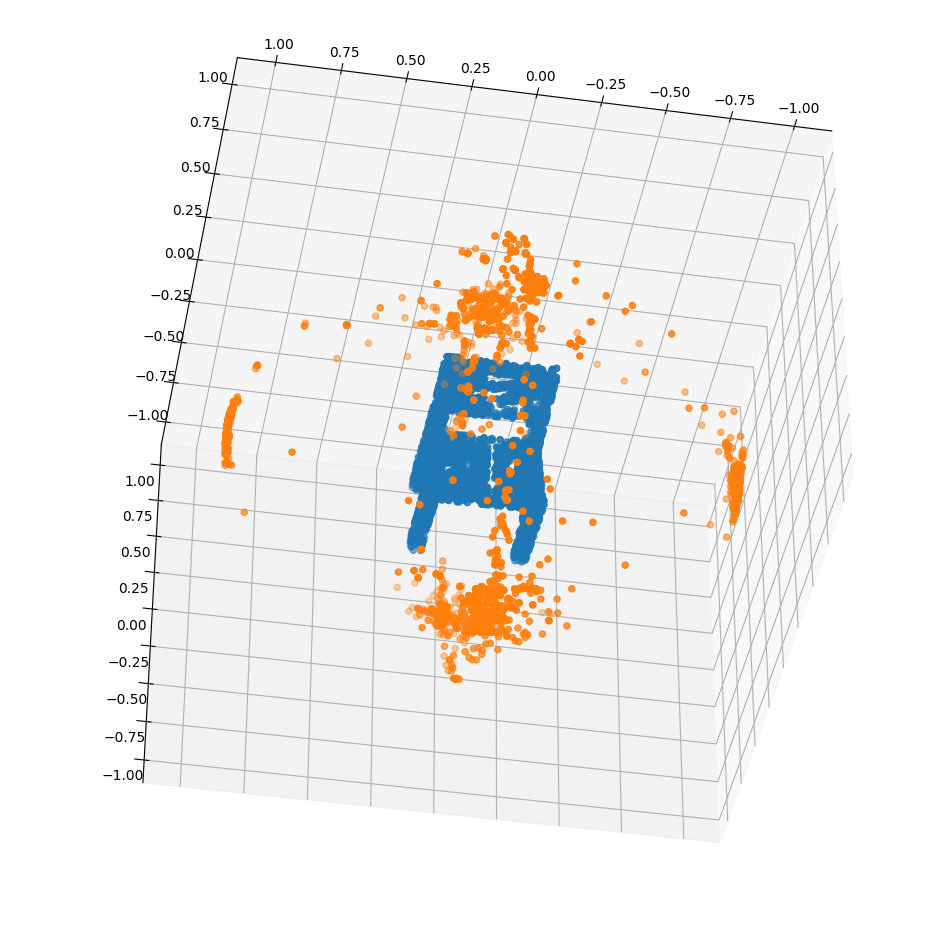

In [88]:
# %matplotlib widget
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(projection='3d')
ax.view_init(elev=-40, azim=80)

_ = ax.scatter(sampled_points_normals_inside[:4096, 0], sampled_points_normals_inside[:4096, 1], sampled_points_normals_inside[:4096, 2], marker='o')
_ = ax.scatter(sampled_points_normals_inside[:4096, 3], sampled_points_normals_inside[:4096, 4], sampled_points_normals_inside[:4096, 5], marker='o')


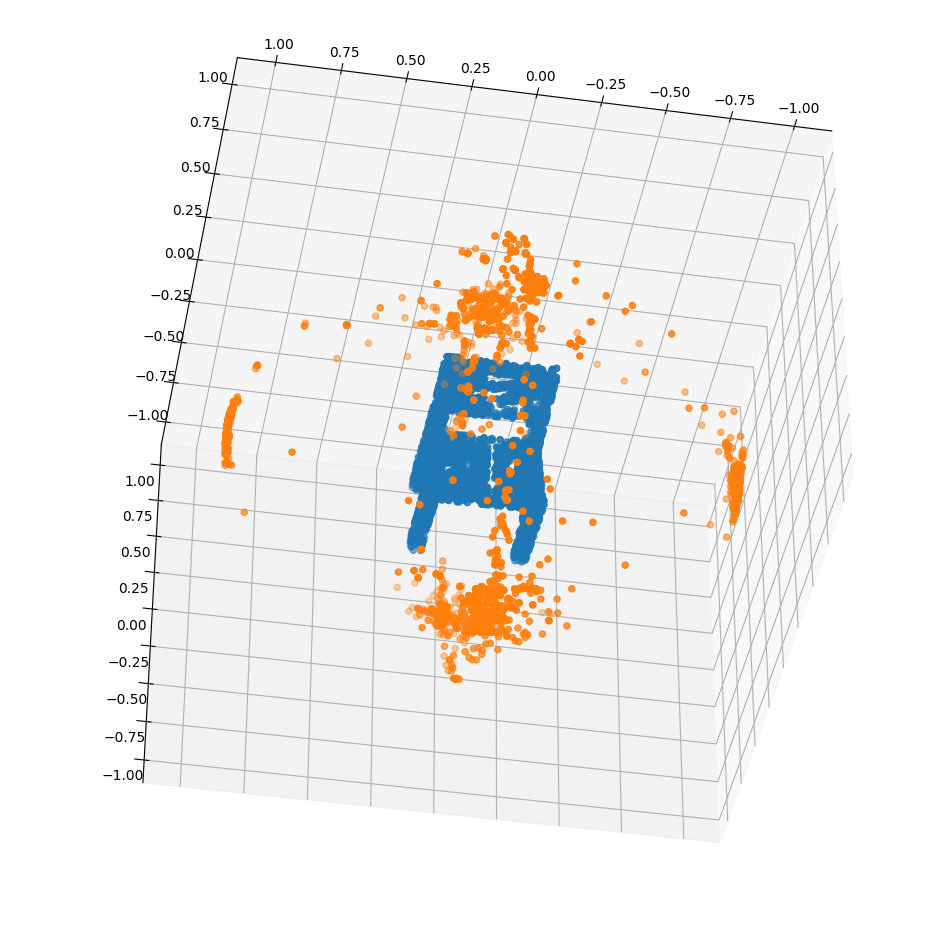

In [89]:
# %matplotlib widget
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(projection='3d')
ax.view_init(elev=-40, azim=80)

_ = ax.scatter(sampled_points_normals_inside[:4096, 0], sampled_points_normals_inside[:4096, 1], sampled_points_normals_inside[:4096, 2], marker='o')
_ = ax.scatter(sampled_points_normals_inside[:4096, 3], sampled_points_normals_inside[:4096, 4], sampled_points_normals_inside[:4096, 5], marker='o')

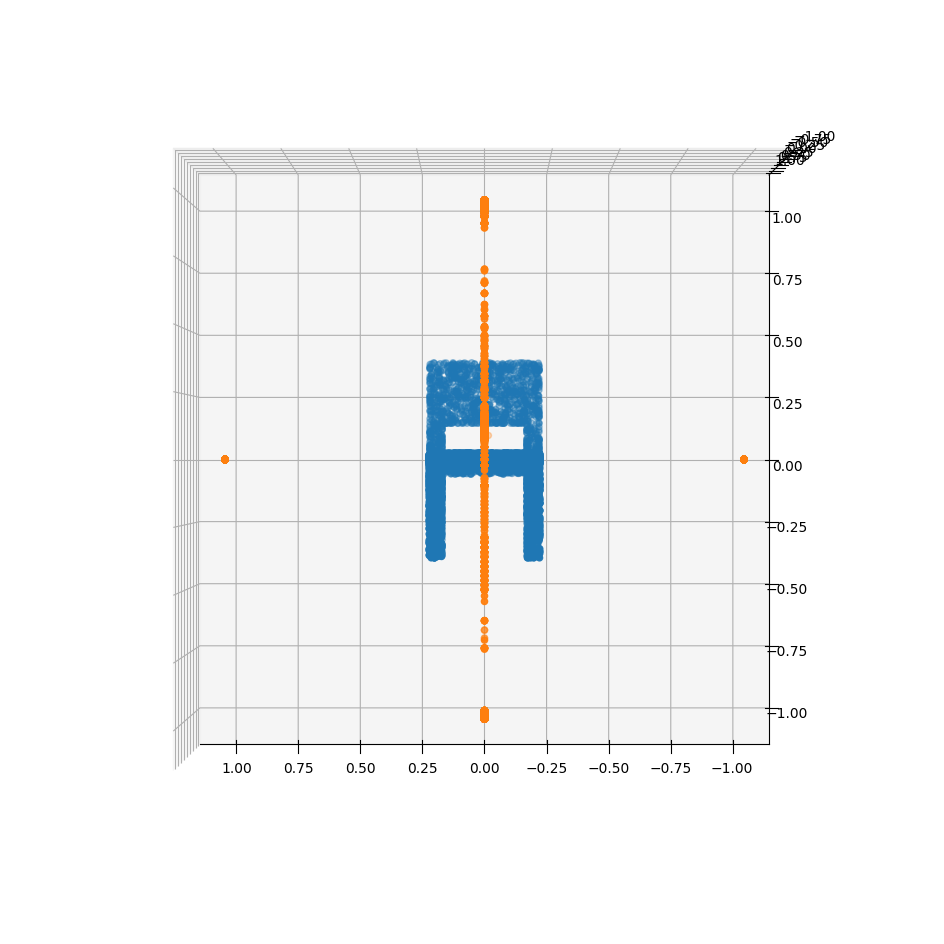

In [90]:
from utils.ply_utils import read_ply_point_normal

gt_normal_ply = os.path.join('/path/to/datasets/shapenet/pointcloud_surface', f'{obj_path}.ply')
vertices_normal_gt, normals_gt = read_ply_point_normal(gt_normal_ply)

ax = plt.figure(figsize=(12, 12)).add_subplot(projection='3d')
ax.view_init(elev=-90, azim=90)
_ = ax.scatter(vertices_normal_gt[:4096, 0], vertices_normal_gt[:4096, 1], vertices_normal_gt[:4096, 2], marker='o')
_ = ax.scatter(normals_gt[:4096, 0], normals_gt[:4096, 1], normals_gt[:4096, 2], marker='o')

In [91]:
def write_ply_point_normal(name, vertices, normals=None):
    fout = open(name, 'w')
    fout.write("ply\n")
    fout.write("format ascii 1.0\n")
    fout.write("element vertex "+str(len(vertices))+"\n")
    fout.write("property float x\n")
    fout.write("property float y\n")
    fout.write("property float z\n")
    fout.write("property float nx\n")
    fout.write("property float ny\n")
    fout.write("property float nz\n")
    fout.write("end_header\n")
    if normals is None:
        for ii in range(len(vertices)):
            fout.write(str(vertices[ii,0])+" "+str(vertices[ii,1])+" "+str(vertices[ii,2])+" "+str(vertices[ii,3])+" "+str(vertices[ii,4])+" "+str(vertices[ii,5])+"\n")
    else:
        for ii in range(len(vertices)):
            fout.write(str(vertices[ii,0])+" "+str(vertices[ii,1])+" "+str(vertices[ii,2])+" "+str(normals[ii,0])+" "+str(normals[ii,1])+" "+str(normals[ii,2])+"\n")
    fout.close()

In [116]:
np.random.shuffle(sampled_points_normals_inside)
write_ply_point_normal("test_pc.ply", sampled_points_normals_inside[:4096])

## Edge CD

In [117]:
from utils.ply_utils import read_ply_point_normal

vertices_gt, normals_gt = read_ply_point_normal(f'/path/to/datasets/shapenet/pointcloud_surface/{obj_path}.ply')
vertices_pd, normals_pd = read_ply_point_normal('./test_pc.ply')

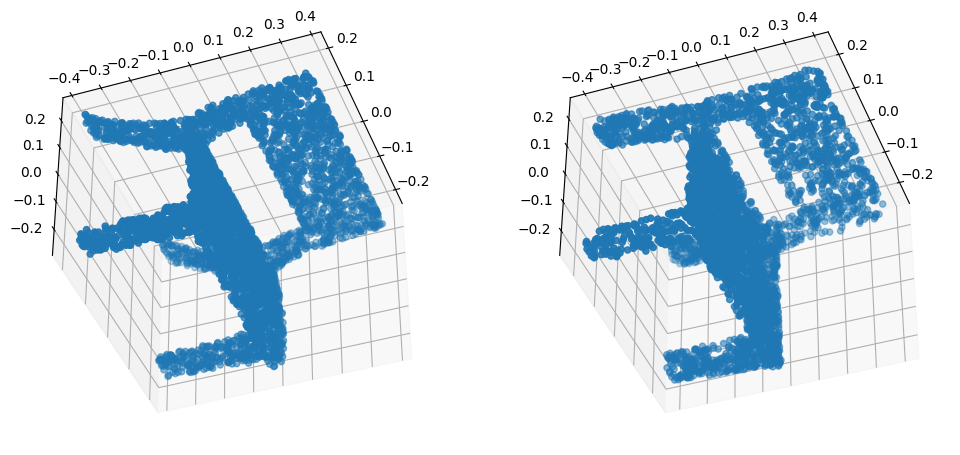

In [118]:
fig = plt.figure(figsize=(12, 12))

ax = fig.add_subplot(121, projection='3d')
ax.view_init(elev=-40, azim=20)
_ = ax.scatter(vertices_gt[:, 0], vertices_gt[:, 1], vertices_gt[:, 2], marker='o')

ax = fig.add_subplot(122, projection='3d')
ax.view_init(elev=-40, azim=20)
_ = ax.scatter(vertices_pd[:, 0], vertices_pd[:, 1], vertices_pd[:, 2], marker='o')

In [121]:
in_points = vertices_gt.copy()
in_normals = normals_gt.copy()

num_points = in_points.shape[0]

points_tiled_mat1 = np.tile(in_points.reshape(num_points, 1, 3), [1,num_points,1])
points_tiled_mat2 = np.tile(in_points.reshape(1, num_points, 3), [num_points,1,1])
dist_points = np.square(points_tiled_mat1 - points_tiled_mat2).sum(axis=2)
close_index = (dist_points<1e-2).astype(np.int8)

normals_tiled_mat1 = np.tile(in_normals.reshape(num_points, 1, 3), [1,num_points,1])
normals_tiled_mat2 = np.tile(in_normals.reshape(1, num_points, 3), [num_points,1,1])
dist_normals = (normals_tiled_mat1 * normals_tiled_mat2).sum(axis=2)
all_edge_index = (np.abs(dist_normals) < 0.1).astype(np.int8)

edge_index = (close_index * all_edge_index).max(axis=1)

all_points = np.concatenate([in_points, in_normals], axis=1)
points_on_edges = all_points[edge_index > 0.5]
np.random.shuffle(points_on_edges)
points_on_edges.shape

(3101, 6)

In [134]:
close_index = (dist_points<1e-4).astype(np.int8)
all_edge_index = (np.abs(dist_normals) < 0.1).astype(np.int8)

edge_index = (close_index * all_edge_index).max(axis=1)

all_points = np.concatenate([in_points, in_normals], axis=1)
points_on_edges = all_points[edge_index > 0.5]
np.random.shuffle(points_on_edges)
points_on_edges.shape

(350, 6)

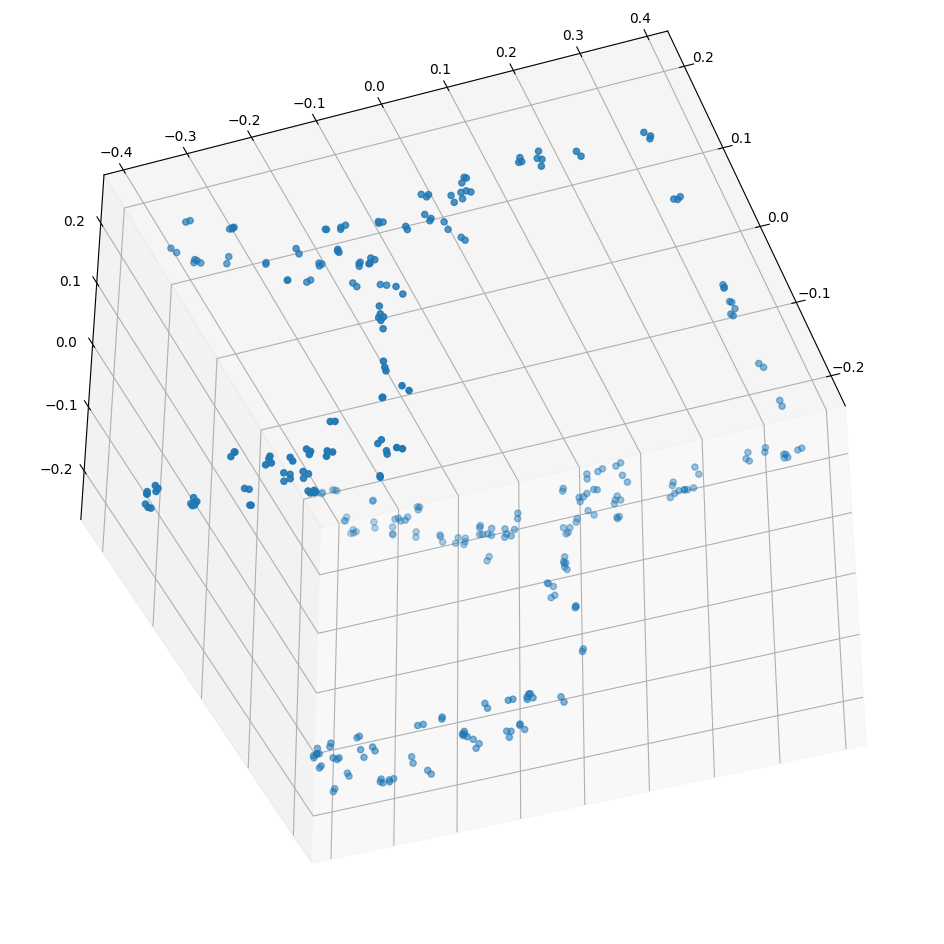

In [135]:
ax = plt.figure(figsize=(12, 12)).add_subplot(projection='3d')
ax.view_init(elev=-40, azim=20)
_ = ax.scatter(points_on_edges[:, 0], points_on_edges[:, 1], points_on_edges[:, 2], marker='o')
# _ = ax.scatter(points_on_edges[:, 3], points_on_edges[:, 4], points_on_edges[:, 5], marker='o')

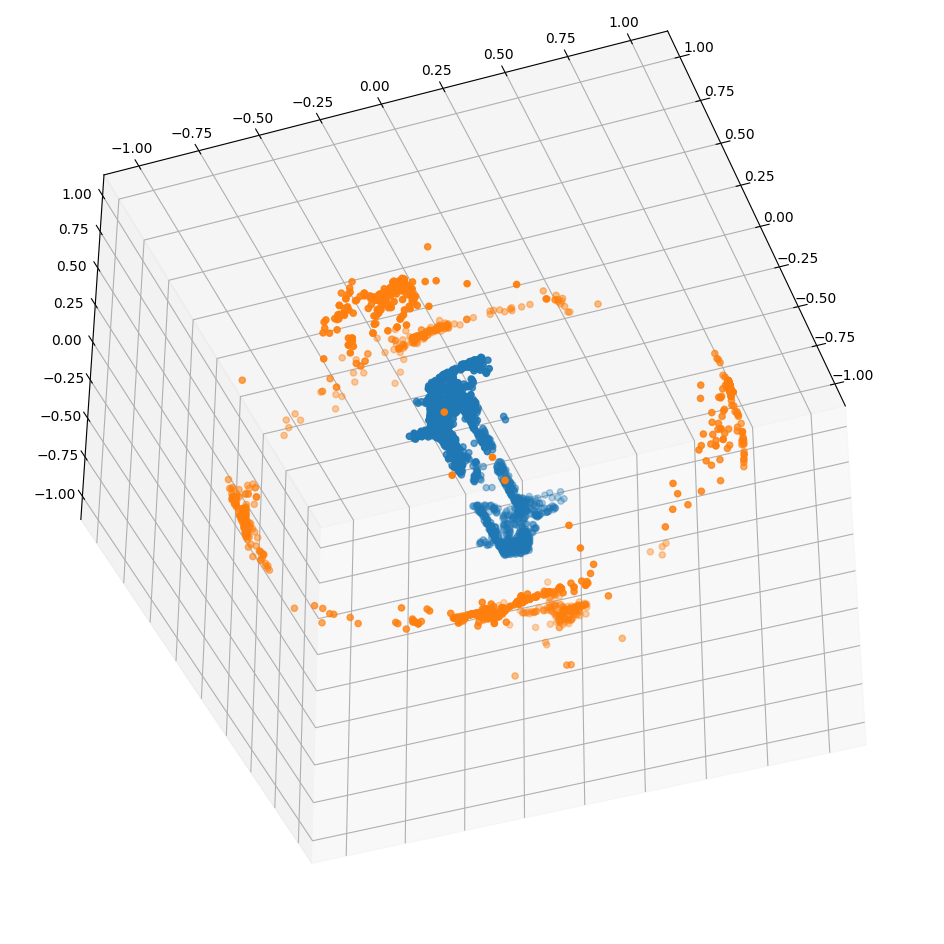

In [50]:
ax = plt.figure(figsize=(12, 12)).add_subplot(projection='3d')
ax.view_init(elev=-40, azim=20)
_ = ax.scatter(points_on_edges[:, 0], points_on_edges[:, 1], points_on_edges[:, 2], marker='o')
_ = ax.scatter(points_on_edges[:, 3], points_on_edges[:, 4], points_on_edges[:, 5], marker='o')

## Other tests....

In [123]:
def read_ply_point_normal(shape_name):
    file = open(shape_name,'r')
    lines = file.readlines()

    start = 0
    while True:
        line = lines[start].strip()
        if line == "end_header":
            start += 1
            break
        line = line.split()
        if line[0] == "element":
            if line[1] == "vertex":
                vertex_num = int(line[2])
        start += 1

    vertices = np.zeros([vertex_num,3], np.float32)
    normals = np.zeros([vertex_num,3], np.float32)
    for i in range(vertex_num):
        line = lines[i+start].split()
        vertices[i,0] = float(line[0]) #X
        vertices[i,1] = float(line[1]) #Y
        vertices[i,2] = float(line[2]) #Z
        normals[i,0] = float(line[3]) #normalX
        normals[i,1] = float(line[4]) #normalY
        normals[i,2] = float(line[5]) #normalZ
    return vertices, normals

In [124]:
obj_path

'02691156/f0bd0660d9cec23cf2b0736dd4d8afe0'

In [125]:
vertices_gt, normals_gt = read_ply_point_normal(f'/path/to/datasets/shapenet/pointcloud_surface/{obj_path}.ply')
vertices_pd, normals_pd = read_ply_point_normal('./test_pc.ply')

In [126]:
from evaluation.eval import calculate_cd, calculate_normal_consistency

cd = calculate_cd(vertices_gt, vertices_pd)

normal_consistency = calculate_normal_consistency(
    vertices_gt, vertices_pd,
    normals_gt, normals_pd
)
cd, normal_consistency

(0.0001041198102029739, 0.8673924207687378)

In [ ]:
# old (0.00010297744302079082, 0.8671811819076538)
# new (0.0001041198102029739, 0.8673924207687378)

In [1]:
import numpy as np

a = np.random.randn(32, 16, 8)
b = np.random.randn(32, 16, 8)
b[a > 1e-3]

array([ 0.18081034, -1.27382435, -0.86481259, ..., -0.3057861 ,
       -0.30243984,  2.80449699])

In [24]:
import numpy as np
import random
import argparse
import importlib
import os

import sys
sys.path.append('../')

from data.data import ImNetImageSamples
from evaluation.eval_utils import read_ply_point_normal


def calculate_cd(gt_points, pd_points):
    gt_num_points = gt_points.shape[0]
    pd_num_points = pd_points.shape[0]

    gt_points_tiled = np.tile(gt_points.reshape(gt_num_points, 1, 3), [1, pd_num_points, 1])
    pd_points_tiled = np.tile(pd_points.reshape(1, pd_num_points, 3), [gt_num_points, 1, 1])

    dist = ((gt_points_tiled - pd_points_tiled) ** 2).sum(axis=2)
    match_pd_gt = np.argmin(dist, axis=0)
    match_gt_pd = np.argmin(dist, axis=1)

    dist_pd_gt = ((pd_points - gt_points[match_pd_gt]) ** 2).mean() * 3
    dist_gt_pd = ((gt_points - pd_points[match_gt_pd]) ** 2).mean() * 3
    chamfer_distance = dist_pd_gt + dist_gt_pd

    return chamfer_distance


def calculate_normal_consistency(gt_points, pd_points, gt_normals, pd_normals):
    gt_num_points = gt_points.shape[0]
    pd_num_points = pd_points.shape[0]

    gt_points_tiled = np.tile(gt_points.reshape(gt_num_points, 1, 3), [1, pd_num_points, 1])
    pd_points_tiled = np.tile(pd_points.reshape(1, pd_num_points, 3), [gt_num_points, 1, 1])

    dist = ((gt_points_tiled - pd_points_tiled) ** 2).sum(axis=2)
    match_pd_gt = np.argmin(dist, axis=0)
    match_gt_pd = np.argmin(dist, axis=1)

    # Handle normals that point into wrong direction gracefully
    # (mostly due to mehtod not caring about this in generation)
    normals_dot_pd_gt = (np.abs((pd_normals * gt_normals[match_pd_gt]).sum(axis=1))).mean()
    normals_dot_gt_pd = (np.abs((gt_normals * pd_normals[match_gt_pd]).sum(axis=1))).mean()
    normal_consistency = (normals_dot_pd_gt + normals_dot_gt_pd) / 2

    return normal_consistency

In [2]:
samples = ImNetImageSamples(
    data_path='../data/all_vox256_img/all_vox256_img_test.hdf5', 
    label_txt_path='../data/all_vox256_img/all_vox256_img_test.txt'
)

In [3]:
# Setup parameters 
cd_res_per_class_dict = dict([
    (name, []) 
    for name in list(set(map(lambda x: x.split('/')[0], samples.obj_paths)))
])

normal_cons_res_per_class_dict = dict([
    (name, []) 
    for name in list(set(map(lambda x: x.split('/')[0], samples.obj_paths)))
])

eval_args = [
    (
        samples.data_points[i][np.squeeze(samples.data_values[i] > 1e-3)], 
        os.path.join('/path/to/nt_test/pretrain_ply', samples.obj_paths[i], 'obj_deformed.ply'), 
        os.path.join('/path/to/nt_test/pretrain_ply', samples.obj_paths[i], 'obj_orginal.ply'), 
        os.path.join('/path/to/nt_test/pretrain_ply', samples.obj_paths[i], 'obj_normals.ply'), 
        os.path.join('/path/to/datasets/shapenet/pointcloud_surface', f'{samples.obj_paths[i]}.ply') ,
        samples.obj_paths[i]
    ) 
    for i in range(len(samples))
]

In [4]:
vertices_gt, pd_ply, _, pd_normals_ply, gt_normal_ply, obj_path = eval_args[4]

In [ ]:
obj_path = '02691156/d199612c22fe9313f4fb6842b3610149'
pd_normals_ply = os.path.join('/path/to/nt_test/pretrain_ply', obj_path, 'obj_normals.ply')
gt_normal_ply = os.path.join('/path/to/datasets/shapenet/pointcloud_surface', f'{obj_path}.ply')
pd_normals_ply, gt_normal_ply

In [26]:
class_name = obj_path.split('/')[0]

In [27]:
pd_points, pd_normals = read_ply_point_normal(pd_normals_ply)
gt_points, gt_normals = read_ply_point_normal(gt_normal_ply)

gt_num_points = gt_points.shape[0]
pd_num_points = pd_points.shape[0]

gt_points_tiled = np.tile(gt_points.reshape(gt_num_points, 1, 3), [1, pd_num_points, 1])
pd_points_tiled = np.tile(pd_points.reshape(1, pd_num_points, 3), [gt_num_points, 1, 1])
gt_normals.shape, pd_normals.shape

((4096, 3), (4096, 3))

In [28]:
dist = ((gt_points_tiled - pd_points_tiled) ** 2).sum(axis=2)
match_pd_gt = np.argmin(dist, axis=0)
match_gt_pd = np.argmin(dist, axis=1)
dist.shape, match_pd_gt.shape, match_gt_pd.shape

((4096, 4096), (4096,), (4096,))

In [29]:
# Handle normals that point into wrong direction gracefully
# (mostly due to mehtod not caring about this in generation)
normals_dot_pd_gt = (np.abs(pd_normals * gt_normals[match_pd_gt]).sum(axis=1)).mean()
normals_dot_gt_pd = (np.abs(gt_normals * pd_normals[match_gt_pd]).sum(axis=1)).mean()
normal_consistency = (normals_dot_pd_gt + normals_dot_gt_pd) / 2.0
normals_dot_pd_gt, normals_dot_gt_pd, normal_consistency

(0.8733151, 0.8393523, 0.8563337326049805)

In [30]:
pd_normals.shape

(4096, 3)

In [31]:
vertices_pd, normals_pd = read_ply_point_normal(pd_normals_ply)
vertices_gt, normals_gt = read_ply_point_normal(gt_normal_ply)

normal_cons_calc = calculate_normal_consistency(
    vertices_gt, vertices_pd, 
    normals_gt, normals_pd
)
normal_cons_calc

0.8082917332649231

In [32]:
cd_calc = calculate_cd(vertices_pd, vertices_gt)
cd_calc

0.008553629153539077